In [1]:
import numpy as np
import numpy.polynomial as P
import scipy as sp
from matplotlib import pyplot as plt
from tqdm import tqdm
#from sklearn.preprocessing import PolynomialFeatures
from multiprocessing import Pool
import multiprocessing
import ZVnbrosse
from sklearn.preprocessing import PolynomialFeatures
from potentials import GaussPotential,GaussMixture,GausMixtureIdent,GausMixtureSame,BananaShape
from samplers import MCMC_sampler,Generate_train,ULA_light
from baselines import set_function,construct_ESVM_kernel,GenerateSigma
from martingale import approx_q
from optimize import Run_eval_test,optimize_parallel_new 
from utils import * 
import copy

In [2]:
def H(k, x):
    if k==0:
        return 1.0
    if k ==1:
        return x
    if k==2:
        return (x**2 - 1)/np.sqrt(2)
    c = np.zeros(k+1,dtype = float)
    c[k] = 1.0
    h = P.hermite_e.hermeval(x,c) / np.sqrt(sp.special.factorial(k)) 
    return h

def compute_H(k,x):
    return H(k[0],x[:,0])*H(k[1],x[:,1])

In [3]:
def test_traj(coefs_poly_regr,gamma,r_seed,lag,d,cov,N_test,x0):
    """
    function to perform 1-dimensional martingale decomposition
    """
    X_test,Noise = generate_traj(x0,N_test,gamma,r_seed,d,cov)
    test_stat_vanilla = np.zeros(N_test,dtype = float)
    test_stat_vr = np.zeros_like(test_stat_vanilla)
    #compute number of basis polynomials
    basis_funcs = np.array([[1,0],[0,1],[1,1],[2,0],[0,2]])
    num_basis_funcs = len(basis_funcs)
    #compute polynomials of noise variables Z_l
    poly_vals = np.zeros((num_basis_funcs,N_test), dtype = float)
    for k in range(len(basis_funcs)):
        poly_vals[k,:] = compute_H(basis_funcs[k],Noise)
    #initialize function
    f_vals_vanilla = np.sum(np.sin(X_test),axis=1)
    #array to store control variates values
    cvfs = np.zeros_like(f_vals_vanilla)
    #compute coeffitients bar_a
    bar_a_0_1 = np.zeros((lag,N_test),dtype=float)
    bar_a_1_0 = np.zeros_like(bar_a_0_1)
    bar_a_1_1 = np.zeros_like(bar_a_0_1)
    bar_a_2_0 = np.zeros_like(bar_a_0_1)
    bar_a_0_2 = np.zeros_like(bar_a_0_1)
    for i in range(lag):
        #coefficients with H_0_1
        bar_a_0_1[i,1:] = coefs_poly_regr[i,1]*cov[0,1]*np.sqrt(gamma)*sigma(X_test[:-1])[:,0]+\
                        coefs_poly_regr[i,2]*cov[1,1]*np.sqrt(gamma)*sigma(X_test[:-1])[:,1]+\
                        2*coefs_poly_regr[i,3]*cov[0,1]*np.sqrt(gamma)*sigma(X_test[:-1])[:,0]*(X_test[:-1]+gamma*b(X_test[:-1]))[:,0]+\
                        coefs_poly_regr[i,4]*(((X_test[:-1]+gamma*b(X_test[:-1]))[:,0])*sigma(X_test[:-1])[:,1]*np.sqrt(gamma)*cov[1,1] +\
                                             ((X_test[:-1]+gamma*b(X_test[:-1]))[:,1])*sigma(X_test[:-1])[:,0]*np.sqrt(gamma)*cov[0,1])+\
                        2*coefs_poly_regr[i,5]*cov[1,1]*np.sqrt(gamma)*sigma(X_test[:-1])[:,1]*(X_test[:-1]+gamma*b(X_test[:-1]))[:,1]
        bar_a_0_1[i,0] = coefs_poly_regr[i,1]*cov[0,1]*np.sqrt(gamma)*sigma(x0)[0]+\
                        coefs_poly_regr[i,2]*cov[1,1]*np.sqrt(gamma)*sigma(x0)[1]+\
                        2*coefs_poly_regr[i,3]*cov[0,1]*np.sqrt(gamma)*sigma(x0)[0]*(x0+gamma*b(x0))[0]+\
                        coefs_poly_regr[i,4]*(((x0+gamma*b(x0))[0])*sigma(x0)[1]*np.sqrt(gamma)*cov[1,1] +\
                                             ((x0+gamma*b(x0))[1])*sigma(x0)[0]*np.sqrt(gamma)*cov[0,1])+\
                        2*coefs_poly_regr[i,5]*cov[1,1]*np.sqrt(gamma)*sigma(x0)[1]*(x0+gamma*b(x0))[1]
        #coefficients with H_1_0
        bar_a_1_0[i,1:] = coefs_poly_regr[i,1]*cov[0,0]*np.sqrt(gamma)*sigma(X_test[:-1])[:,0]+\
                        coefs_poly_regr[i,2]*cov[0,1]*np.sqrt(gamma)*sigma(X_test[:-1])[:,1]+\
                        2*coefs_poly_regr[i,3]*cov[0,0]*np.sqrt(gamma)*sigma(X_test[:-1])[:,0]*(X_test[:-1]+gamma*b(X_test[:-1]))[:,0]+\
                        coefs_poly_regr[i,4]*(((X_test[:-1]+gamma*b(X_test[:-1]))[:,0])*sigma(X_test[:-1])[:,1]*np.sqrt(gamma)*cov[0,1] +\
                                             ((X_test[:-1]+gamma*b(X_test[:-1]))[:,1])*sigma(X_test[:-1])[:,0]*np.sqrt(gamma)*cov[0,0])+\
                        2*coefs_poly_regr[i,5]*cov[0,1]*np.sqrt(gamma)*sigma(X_test[:-1])[:,1]*(X_test[:-1]+gamma*b(X_test[:-1]))[:,1]
        bar_a_1_0[i,0] = coefs_poly_regr[i,1]*cov[0,0]*np.sqrt(gamma)*sigma(x0)[0]+\
                        coefs_poly_regr[i,2]*cov[0,1]*np.sqrt(gamma)*sigma(x0)[1]+\
                        2*coefs_poly_regr[i,3]*cov[0,0]*np.sqrt(gamma)*sigma(x0)[0]*(x0+gamma*b(x0))[0]+\
                        coefs_poly_regr[i,4]*(((x0+gamma*b(x0))[0])*sigma(x0)[1]*np.sqrt(gamma)*cov[0,1] +\
                                             ((x0+gamma*b(x0))[1])*sigma(x0)[0]*np.sqrt(gamma)*cov[0,0]) +\
                        2*coefs_poly_regr[i,5]*cov[0,1]*np.sqrt(gamma)*sigma(x0)[1]*(x0+gamma*b(x0))[1]
        #second-order coefficients
        bar_a_1_1[i,1:] = coefs_poly_regr[i,4]*gamma#+\
                        #2*coefs_poly_regr[i,7]*gamma*(X_test[:-1]+gamma*b(X_test[:-1]))[:,0] +\
                        #*coefs_poly_regr[i,8]*gamma*(X_test[:-1]+gamma*b(X_test[:-1]))[:,1] 
        bar_a_1_1[i,0] = coefs_poly_regr[i,4]*gamma#+\
                        #2*coefs_poly_regr[i,7]*gamma*(x0+gamma*b(x0))[0] +\
                        #2*coefs_poly_regr[i,8]*gamma*(x0+gamma*b(x0))[1] 
        #coefficients with H_2_0
        bar_a_2_0[i,1:] = np.sqrt(2)*coefs_poly_regr[i,3]*gamma #+\
                        #3*np.sqrt(2)*coefs_poly_regr[i,6]*gamma*(X_test[:-1]+gamma*b(X_test[:-1]))[:,0] +\
                        #np.sqrt(2)*coefs_poly_regr[i,7]*gamma*(X_test[:-1]+gamma*b(X_test[:-1]))[:,1]
        bar_a_2_0[i,0] = np.sqrt(2)*coefs_poly_regr[i,3]*gamma #+\
                        #3*np.sqrt(2)*coefs_poly_regr[i,6]*gamma*(x0+gamma*b(x0))[0] +\
                        #np.sqrt(2)*coefs_poly_regr[i,7]*gamma*(x0+gamma*b(x0))[1]
        #coefficients with H_0_2
        bar_a_0_2[i,1:] = np.sqrt(2)*coefs_poly_regr[i,5]*gamma #+\
                        #3*np.sqrt(2)*coefs_poly_regr[i,9]*gamma*(X_test[:-1]+gamma*b(X_test[:-1]))[:,0] +\
                        #np.sqrt(2)*coefs_poly_regr[i,8]*gamma*(X_test[:-1]+gamma*b(X_test[:-1]))[:,1]
        bar_a_0_2[i,0] = np.sqrt(2)*coefs_poly_regr[i,5]*gamma #+\
                        #3*np.sqrt(2)*coefs_poly_regr[i,9]*gamma*(x0+gamma*b(x0))[0] +\
                        #np.sqrt(2)*coefs_poly_regr[i,8]*gamma*(x0+gamma*b(x0))[1]
    bar_a_1_0 = bar_a_1_0*poly_vals[0,:]
    bar_a_0_1 = bar_a_0_1*poly_vals[1,:]
    bar_a_1_1 = bar_a_1_1*poly_vals[2,:]
    bar_a_2_0 = bar_a_2_0*poly_vals[3,:]
    bar_a_0_2 = bar_a_0_2*poly_vals[4,:]
    #compute martingale sums
    M_n_0_1 = 0.0
    M_n_1_0 = 0.0
    M_n_1_1 = 0.0
    M_n_2_0 = 0.0
    M_n_0_2 = 0.0
    for l in range(N_test):
        for r in range(min(N_test-l,lag)):
            M_n_0_1 += bar_a_0_1[r,l]
            M_n_1_0 += bar_a_1_0[r,l]
            M_n_1_1 += bar_a_1_1[r,l]
            M_n_2_0 += bar_a_2_0[r,l]
            M_n_0_2 += bar_a_0_2[r,l]
    return np.mean(f_vals_vanilla), np.mean(f_vals_vanilla)-(M_n_0_1 + M_n_1_0)/N_test, np.mean(f_vals_vanilla)-(M_n_0_1 + M_n_1_0 + M_n_1_1 + M_n_2_0 + M_n_0_2)/N_test
#
#
#

In [4]:
def approx_q_enhanced(X_train,Y_train,N_traj_train,lag,max_deg):
    """
    Function to regress q functions on a polynomial basis;
    Args:
        X_train - train tralectory;
        Y_train - function values;
        N_traj_train - number of training trajectories;
        lag - truncation point for coefficients, those for |p-l| > lag are set to 0;
        max_deg - maximum degree of polynomial in regression
    """
    dim = X_train[0,:].shape[0]
    #print("dimension = ",dim)
    coefs_poly = np.array([])
    for i in range(lag):
        x_all = np.array([])
        y_all = np.array([])
        for j in range(N_traj_train):
            y = Y_train[j,i:,0]
            if i == 0:
                x = X_train[j,:]
            else:
                x = X_train[j,:-i]
            #concatenate results
            if x_all.size == 0:
                x_all = x
            else:
                x_all = np.concatenate((x_all,x),axis = 0)
            y_all = np.concatenate([y_all,y])
        #should use polyfeatures here
        #print("variance: ",np.var(y_all))
        #print(y_all[:50])
        poly = PolynomialFeatures(max_deg)
        X_features = poly.fit_transform(x_all)
        sin_features = np.sin(X_features)
        cos_features = np.cos(X_features)
        All_features = np.concatenate((X_features,sin_features,cos_features),axis=1)
        print(All_features.shape)
        #print(X_features.shape)
        lstsq_results = np.linalg.lstsq(All_features,y_all,rcond = None)
        coefs = copy.deepcopy(lstsq_results[0])
        coefs.resize((1,All_features.shape[1]))           
        if coefs_poly.size == 0:
            coefs_poly = copy.deepcopy(coefs)
        else:
            coefs_poly = np.concatenate((coefs_poly,coefs),axis=0)
    return coefs_poly

def approx_q_poly(X_train,Y_train,N_traj_train,lag,max_deg):
    """
    Function to regress q functions on a polynomial basis;
    Args:
        X_train - train tralectory;
        Y_train - function values;
        N_traj_train - number of training trajectories;
        lag - truncation point for coefficients, those for |p-l| > lag are set to 0;
        max_deg - maximum degree of polynomial in regression
    """
    dim = X_train[0,:].shape[0]
    #print("dimension = ",dim)
    coefs_poly = np.array([])
    for i in range(lag):
        x_all = np.array([])
        y_all = np.array([])
        for j in range(N_traj_train):
            y = Y_train[j,i:,0]
            if i == 0:
                x = X_train[j,:]
            else:
                x = X_train[j,:-i]
            #concatenate results
            if x_all.size == 0:
                x_all = x
            else:
                x_all = np.concatenate((x_all,x),axis = 0)
            y_all = np.concatenate([y_all,y])
        #should use polyfeatures here
        #print("variance: ",np.var(y_all))
        #print(y_all[:50])
        poly = PolynomialFeatures(max_deg)
        X_features = poly.fit_transform(x_all)
        #print(X_features.shape)
        lstsq_results = np.linalg.lstsq(X_features,y_all,rcond = None)
        coefs = copy.deepcopy(lstsq_results[0])
        coefs.resize((1,X_features.shape[1]))           
        if coefs_poly.size == 0:
            coefs_poly = copy.deepcopy(coefs)
        else:
            coefs_poly = np.concatenate((coefs_poly,coefs),axis=0)
    return coefs_poly

In [5]:
a = 0.0
sig = 1.0
cov = np.array([[1,0.0],[0.0,1]])

def b(X_t):
    """
    b function in the diffusion
    """
    #return a*(c-X_t)
    if len(X_t.shape) == 1:
        return -np.array([X_t[0] + a*np.sin(X_t[1]),X_t[1] + a*np.sin(X_t[0])])
    else:
        return -np.transpose(np.array([X_t[:,0] + a*np.sin(X_t[:,1]),X_t[:,1] + a*np.sin(X_t[:,0])]))

def sigma(X_t):
    """
    b function in the diffusion
    """
    return sig*np.ones_like(X_t)

def sample_discretized_diffusion(X_t,gamma_t,d,cov):
    """
    args:   X_t - current value, 
            gamma_t - step size;
            d - dimension;
            cov - covariance matrix
    returns:  (X_{t+1},xi_{t+1}) - value at the next time moment and the corresponding noise variable
    """
    xi = np.random.randn(d)
    return X_t + gamma_t*b(X_t) + np.sqrt(gamma_t)*sigma(X_t)*(cov @ xi),xi

#currently we use this function without the burn-in
def generate_traj(x0,n,gamma,r_seed,d,cov):
    """
    args:
        x0 - starting point;
        n - number of steps;
        gamma - step size (assumed to be fixed for now);
    returns:
        x_all,noise_all - np.arrays of shape (n,)  
    """
    x_all = np.zeros((n,d),dtype = float)
    noise_all = np.zeros((n,d),dtype = float)
    np.random.seed(r_seed)
    x_all[0],noise_all[0] = sample_discretized_diffusion(x0,gamma,d,cov)
    for i in range(1,n):
        x_all[i],noise_all[i] = sample_discretized_diffusion(x_all[i-1],gamma,d,cov)
    return x_all,noise_all

def run_monte_carlo(x,f_type):
    if f_type == "quadratic":
        f_vals = x**2
    else:
        raise "not implemented error"
    return np.mean(f_vals,axis=1)

In [6]:
n = 1*10**6 #sample size
gamma = 1e-1 # Step size
n_traj = 1
d = 2
n_traj_test = 100 # Number of independent MCMC trajectories for test
f_type = "linear"
K_max = 2 #max degree of Hermite polynomial
S_max = 2 #max degree of polynomial during regression stage
lag = 300 #maximal lag order
N_test = 1*10**3

Sample discretized diffusion

In [7]:
def generate_observations(x0,n,gamma,r_seed,d,cov):
    X_train, noise_train = generate_traj(x0,n,gamma,r_seed,d,cov)
    #set target function
    Y_train = np.sum(np.sin(X_train),axis=1)
    X_train = X_train.reshape((1,-1,d))
    Y_train = Y_train.reshape((1,-1,1))
    return X_train, noise_train, Y_train

In [8]:
x0 = 1*np.array([0.0,0.0],dtype = float)
r_seed = 1812
X_train, noise_train, Y_train = generate_observations(x0,n,gamma,r_seed,d,cov)
X_train_1, noise_train_1, Y_train_1 = generate_observations(x0,n,2*gamma,r_seed,d,cov)
X_train_2, noise_train_2, Y_train_2 = generate_observations(x0,n,3*gamma,r_seed,d,cov)
X_train_3, noise_train_3, Y_train_3 = generate_observations(x0,n,4*gamma,r_seed,d,cov)
X_train_4, noise_train_4, Y_train_4 = generate_observations(x0,n,5*gamma,r_seed,d,cov)
#X_train_5, noise_train_5, Y_train_5 = generate_observations(x0,n,10*gamma,r_seed,d,cov)

In [9]:
print(X_train_1.shape)

(1, 1000000, 2)


### Bernoulli:: Optimize coefficients by solving regression with polynomial features

In [10]:
#polynomial coefficients
coefs_poly_0 = approx_q_poly(X_train,Y_train,n_traj,lag,S_max)
#coefs_enhanced_0 = approx_q_enhanced(X_train,Y_train,n_traj,lag,S_max)
#coefs_poly_0_2nd = approx_q(X_train,Y_train,n_traj,lag,S_max-1)
coefs_poly = approx_q_poly(X_train_1,Y_train_1,n_traj,lag,S_max)
#coefs_enhanced = approx_q_enhanced(X_train_1,Y_train_1,n_traj,lag,S_max)
#coefs_poly_2nd = approx_q(X_train_1,Y_train_1,n_traj,lag,S_max-1)
coefs_poly_1 = approx_q_poly(X_train_2,Y_train_2,n_traj,lag,S_max)
#coefs_enhanced_1 = approx_q_enhanced(X_train_2,Y_train_2,n_traj,lag,S_max)
#coefs_poly_1_2nd = approx_q(X_train_2,Y_train_2,n_traj,lag,S_max-1)
coefs_poly_2 = approx_q_poly(X_train_3,Y_train_3,n_traj,lag,S_max)
coefs_poly_3 = approx_q_poly(X_train_4,Y_train_4,n_traj,lag,S_max)
#coefs_poly_4 = approx_q(X_train_5,Y_train_5,n_traj,lag,S_max)
print(coefs_poly_0.shape)
#print(coefs_poly.shape)
print(coefs_poly_0)

(300, 6)
[[ 3.07464130e-03  7.68544165e-01  7.68873169e-01 -2.43968851e-03
  -6.63107207e-04 -4.61475386e-03]
 [ 2.66640630e-03  6.92238568e-01  6.91420246e-01 -2.41215333e-03
   5.13866900e-04 -3.34965502e-03]
 [ 2.02653812e-03  6.23597105e-01  6.21746607e-01 -2.13101430e-03
   1.74753592e-03 -1.94929892e-03]
 ...
 [ 3.43049674e-04  3.33931245e-03 -2.99203576e-03  3.05086270e-03
  -1.09730419e-03  3.49345284e-04]
 [ 4.83195856e-04  3.11617404e-03 -2.73972854e-03  2.91924385e-03
  -2.13017733e-03  2.17669155e-04]
 [ 7.57113575e-04  2.75007089e-03 -2.88165447e-03  2.86786795e-03
  -3.00317726e-03 -2.50351875e-04]]


In [11]:
regr_vals_enh = np.zeros((lag,X_train.shape[1]),dtype=float)
regr_vals_poly = np.zeros((lag,X_train.shape[1]),dtype=float)
features = np.zeros((X_train.shape[1],6),dtype=float)
features[:,0] = 1.0
features[:,1:3] = X_train[0,:,:]
features[:,3] = X_train[0,:,0]**2 
features[:,4] = X_train[0,:,0]*X_train[0,:,1]
features[:,5] = X_train[0,:,1]**2
sin_features = np.sin(features)
cos_features = np.cos(features)
All_features = np.concatenate((features,sin_features,cos_features),axis=1)
"""
features[:,6] = X_train_1[0,:,0]**3
features[:,7] = (X_train_1[0,:,0]**2)*X_train_1[0,:,1]
features[:,8] = (X_train_1[0,:,0])*(X_train_1[0,:,1]**2)
features[:,9] = X_train_1[0,:,1]**3
features[:,10] = X_train_1[0,:,0]**4
features[:,11] = (X_train_1[0,:,0]**3)*(X_train_1[0,:,1])
features[:,12] = (X_train_1[0,:,0]**2)*(X_train_1[0,:,1]**2)
features[:,13] = (X_train_1[0,:,0])*(X_train_1[0,:,1]**3)
features[:,14] = X_train_1[0,:,1]**4
"""
for i in range(len(regr_vals_poly)):
    #regr_vals_enh[i,:] = np.sum(coefs_enhanced_0[i,:]*All_features,axis=1)
    regr_vals_poly[i,:] = np.sum(coefs_poly_0[i,:]*features,axis=1)
    #regr_vals_2nd[i,:] = np.sum(coefs_poly_2nd[i,:]*features[:,:10],axis=1)

In [ ]:
err_poly = np.zeros(lag)
err_enhanced = np.zeros_like(err_poly)
for i in range(lag):
    err_enhanced[i] = np.mean((Y_train_1[0,i:,0]-regr_vals_enh[i,:len(Y_train[0,i:,0])])**2)
    err_poly[i] = np.mean((Y_train_1[0,i:,0]-regr_vals_poly[i,:len(Y_train[0,i:,0])])**2)
print(np.sum(err_poly))
#print(np.sum(err_enhanced))

Test our regressors

In [ ]:
cur_lag = 2
N_pts = 500
plt.figure(figsize=(10, 10))
plt.title("Testing regression model",fontsize=20)
plt.plot(Y_train[0,cur_lag:N_pts+cur_lag,0],color='r',label='true function')
plt.plot(regr_vals[cur_lag,:N_pts],color='g',label = 'practical approximation')
plt.legend(loc = 'upper left',fontsize = 16)
plt.show()

In [12]:
N_test = 5000

In [13]:
test_seed = 1453
nbcores = multiprocessing.cpu_count()
trav = Pool(nbcores)
res_0 = trav.starmap(test_traj, [(coefs_poly_0,gamma,test_seed+i,lag,d,cov,N_test,x0) for i in range (n_traj_test)])
#res = trav.starmap(test_traj, [(Cur_pot,coefs_poly,step,test_seed+i,lag,K_max,S_max,N_burn,N_test,d,f_type,inds_arr,params,x0,fixed_start) for i in range (n_traj_test)])
trav.close()
res_new_0 = np.asarray(res_0)
print(res_new_0.shape)

(100, 3)


In [14]:
test_seed = 1453
nbcores = multiprocessing.cpu_count()
trav = Pool(nbcores)
res = trav.starmap(test_traj, [(coefs_poly,2*gamma,test_seed+i,lag,d,cov,N_test,x0) for i in range (n_traj_test)])
#res = trav.starmap(test_traj, [(Cur_pot,coefs_poly,step,test_seed+i,lag,K_max,S_max,N_burn,N_test,d,f_type,inds_arr,params,x0,fixed_start) for i in range (n_traj_test)])
trav.close()
res_new = np.asarray(res)
print(res_new.shape)

(100, 3)


In [15]:
test_seed = 1453
nbcores = multiprocessing.cpu_count()
trav = Pool(nbcores)
res_1 = trav.starmap(test_traj, [(coefs_poly_1,3*gamma,test_seed+i,lag,d,cov,N_test,x0) for i in range (n_traj_test)])
#res = trav.starmap(test_traj, [(Cur_pot,coefs_poly,step,test_seed+i,lag,K_max,S_max,N_burn,N_test,d,f_type,inds_arr,params,x0,fixed_start) for i in range (n_traj_test)])
trav.close()
res_new_1 = np.asarray(res_1)
print(res_new_1.shape)

(100, 3)


In [16]:
test_seed = 1453
nbcores = multiprocessing.cpu_count()
trav = Pool(nbcores)
res_2 = trav.starmap(test_traj, [(coefs_poly_2,4*gamma,test_seed+i,lag,d,cov,N_test,x0) for i in range (n_traj_test)])
#res = trav.starmap(test_traj, [(Cur_pot,coefs_poly,step,test_seed+i,lag,K_max,S_max,N_burn,N_test,d,f_type,inds_arr,params,x0,fixed_start) for i in range (n_traj_test)])
trav.close()
res_new_2 = np.asarray(res_2)
print(res_new_2.shape)

(100, 3)


In [17]:
test_seed = 1453
nbcores = multiprocessing.cpu_count()
trav = Pool(nbcores)
res_3 = trav.starmap(test_traj, [(coefs_poly_3,5*gamma,test_seed+i,lag,d,cov,N_test,x0) for i in range (n_traj_test)])
#res = trav.starmap(test_traj, [(Cur_pot,coefs_poly,step,test_seed+i,lag,K_max,S_max,N_burn,N_test,d,f_type,inds_arr,params,x0,fixed_start) for i in range (n_traj_test)])
trav.close()
res_new_3 = np.asarray(res_3)
print(res_new_3.shape)

(100, 3)


In [ ]:
test_seed = 1453
nbcores = multiprocessing.cpu_count()
trav = Pool(nbcores)
res_4 = trav.starmap(test_traj, [(coefs_poly_4,10*gamma,test_seed+i,lag,d,cov,N_test,x0) for i in range (n_traj_test)])
#res = trav.starmap(test_traj, [(Cur_pot,coefs_poly,step,test_seed+i,lag,K_max,S_max,N_burn,N_test,d,f_type,inds_arr,params,x0,fixed_start) for i in range (n_traj_test)])
trav.close()
res_new_4 = np.asarray(res_4)
print(res_new_4.shape)

### Comparison plots

In [ ]:
title = ""
#labels = ['Vanilla\n Euler scheme', 'Euler scheme \nwith MDCV-1']
labels = ['Vanilla\n Euler scheme', 'Euler scheme \nwith MDCV-1','Euler scheme \nwith MDCV-2']

In [ ]:
data = [res_new_0[:,0],res_new_0[:,1]]#, res_new_0[:,2]] 
boxplot_ind(data, title, labels,path="./2d_nonsymmetric_potential_linear_lag_20.pdf")

In [25]:
def set_axis_style_boxplot(ax, labels, parts):
    colors = (sns.color_palette("muted")[0:7])
    ax.grid(color='black', linestyle='-', linewidth=0.15, alpha=0.6)    
    ax.set_xticks(np.arange(1, len(labels)+1))
    ax.set_xticklabels(labels, fontsize=12)
    ax.set_xlim(0.5, len(labels) + 0.5)
    ax.set_ylim(-0.12, 0.12)
    ax.spines["top"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["right"].set_visible(False)
    
    for pc,i in zip(parts['boxes'],range(len(labels))):
        pc.set(facecolor=colors[i],alpha=0.65)
        pc.set_edgecolor('black')
        pc.set_linewidth(0.65)
    

def boxplot_ind(data, title, labels, path):
    meanprops = dict(linestyle='-', linewidth=1, color='black')
    medianprops = dict(linestyle='', linewidth=0)

    fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(8, 4), sharey=True, frameon=False,dpi=100)      
    fig.suptitle(title, fontsize=20)
    parts = ax1.boxplot(data,  widths=0.6, patch_artist=True, meanline=True, showmeans=True, medianprops=medianprops,meanprops = meanprops, showfliers=False)
    set_axis_style_boxplot(ax1, labels, parts)
    fig.tight_layout()
    fig.subplots_adjust(top=0.85)
    plt.savefig(path)
    plt.show() 

In [26]:
title = ""
#labels = ['Vanilla\n Euler scheme', 'Euler scheme \nwith MDCV-1']
labels = ['MDCV-2, \n $\\gamma = 0.1$', 'MDCV-2, \n $\\gamma = 0.2$',\
          'MDCV-2, \n $\\gamma = 0.3$', 'MDCV-2, \n $\\gamma = 0.4$', 'MDCV-2, \n $\\gamma = 0.5$']#,\
          #'MDCV-2, \n $\\gamma = 0.2$']
#labels = ['lag \n = 10','lag \n = 20', 'lag \n = 30', 'lag \n = 40', 'lag \n = 50', 'lag \n = 60']
#labels = ['lag = 30', 'lag = 40', 'lag = 50', 'lag = 60']

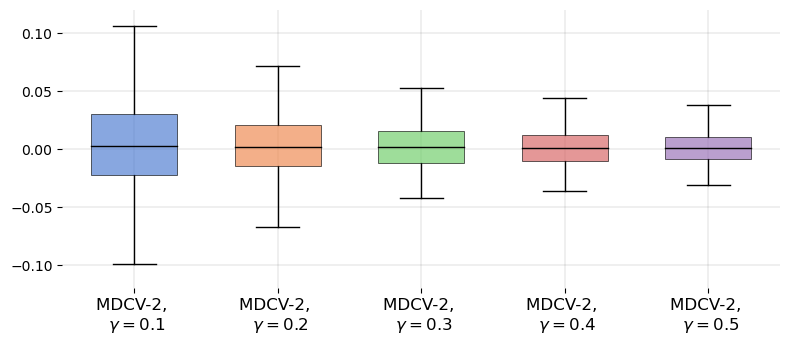

In [27]:
data = [res_new_0[:,0],res_new[:,0],res_new_1[:,0], res_new_2[:,0],res_new_3[:,0]]#,res_new_4[:,1]] 
#data = [res_new_1[:,2], res_new_2[:,2],res_new_3[:,2],res_new_4[:,2]] 
boxplot_ind(data, title, labels,path="./2d_nonsymmetric_potential_gamma_vanilla__influence.pdf")

In [28]:
print(N_test*np.var(res_new_0[:,0]),N_test*np.var(res_new[:,0]),N_test*np.var(res_new_1[:,0]),N_test*np.var(res_new_2[:,0]),N_test*np.var(res_new_3[:,0]))#,N_test*np.var(res_new_4[:,2]))
print(N_test*np.var(res_new_0[:,2]),N_test*np.var(res_new[:,2]),N_test*np.var(res_new_1[:,2]),N_test*np.var(res_new_2[:,2]),N_test*np.var(res_new_3[:,2]))#,N_test*np.var(res_new_4[:,2]))

10.237716501482709 4.9549676592190135 3.191807784415158 2.2945930236876007 1.7420959812814074
0.18640557973437583 0.11136864833734442 0.08465809695821984 0.07017756704479818 0.06354558971376033


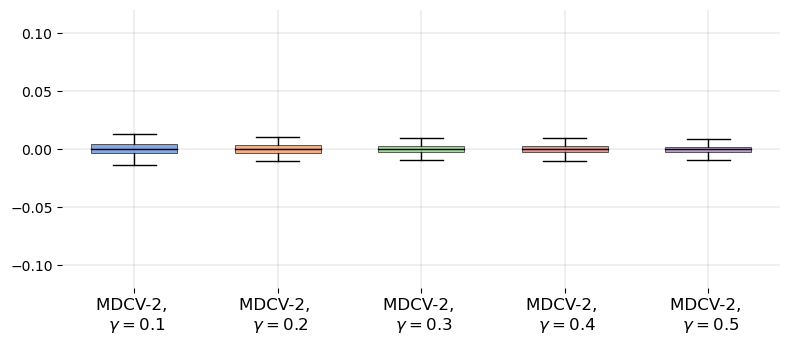

In [29]:
data = [res_new_0[:,2],res_new[:,2],res_new_1[:,2], res_new_2[:,2],res_new_3[:,2]]#,res_new_4[:,2]] 
#data = [res_new_1[:,2], res_new_2[:,2],res_new_3[:,2],res_new_4[:,2]] 
boxplot_ind(data, title, labels,path="./2d_nonsymmetric_potential_gamma_2nd_order__influence.pdf")

In [ ]:
data = [res_new_0[:,2],res_new[:,2],res_new_1[:,2], res_new_2[:,2],res_new_3[:,2]]#,res_new_4[:,2]] 
#data = [res_new_1[:,2], res_new_2[:,2],res_new_3[:,2],res_new_4[:,2]] 
boxplot_ind(data, title, labels,path="./2d_nonsymmetric_potential_gamma_2nd_order__influence.pdf")

In [ ]:
data = [res_new_0[:,0],res_new_0[:,2],res_new[:,2],res_new_1[:,2], res_new_2[:,2],res_new_3[:,2],res_new_4[:,2]] 
#data = [res_new_1[:,2], res_new_2[:,2],res_new_3[:,2],res_new_4[:,2]] 
boxplot_ind(data, title, labels,path="./2d_nonsymmetric_potential_lags_comparison.pdf")